# The Environment

In [56]:
import gymnasium as gym
from gymnasium import spaces, vector
import numpy as np
from scipy.stats import binom, nbinom, beta, poisson, gamma, norm
import csv
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.callbacks import EvalCallback

RESOURCES = 10
PERIODS_PER_SESSION = 100
MAX_PARTS = 10


def create_random_job(name):
    name = name
    
    req_diff = np.maximum(0, norm.rvs(loc=1.2,scale=0.15))
    r = binom.rvs(n=7, p=0.20*req_diff)
    resource_requirement = 1 + r 
    parts = MAX_PARTS

    job_diff = np.maximum(0, norm.rvs(loc=1.4,scale=0.1))
    complication_probability = beta.rvs(a=1.5*job_diff, b=3.5)
    expected_length = 1 + (parts-1)*complication_probability
    
    time_diff = np.minimum(1,np.maximum(0, norm.rvs(loc=0.7, scale=0.1)))
    completion_dist = binom(parts-1, complication_probability)
    soft_deadline = int(min(2*MAX_PARTS, np.ceil(completion_dist.ppf(0.9)/time_diff)))
    hard_deadline = int(min(2*MAX_PARTS, np.ceil(completion_dist.ppf(0.9)/time_diff**1.8)))
    payment = gamma.rvs(a=3, scale=1/180)*(job_diff*req_diff)**0.7*time_diff*expected_length*resource_requirement
    payment = np.maximum(1,int(payment*100))
    return Job(name, resource_requirement, parts, complication_probability, soft_deadline, hard_deadline, payment)
    

def create_job_progression(parts, complication_prob) -> float:
    progression = []
    while parts:
        per_progress = 0
        working = True
        while working:
            parts -= 1
            per_progress += 1
            if parts==0 or np.random.rand() < complication_prob:
                working=False
        progression.append(per_progress)
    return progression


class Job:
    def __init__(self, name, reqs, parts, complication, soft_deadline, hard_deadline, payment):
        self.name = name
        self.resource_requirement = reqs
        self.parts = parts
        self.complication_probability = complication
        self.soft_deadline = soft_deadline
        self.hard_deadline = hard_deadline
        self.payment_orig = payment
        self.parts_orig = self.parts
        self.length = self.expected_length()
        self.payment = self.current_payment()
        self.rate = self.return_rate()
        self.final_payment = -1
        self.progression=create_job_progression(parts, complication)
        
    
    def current_payment(self):
        if self.hard_deadline <= 0:
            return int(np.round(-0.2 * self.payment_orig))
        elif self.soft_deadline <= 0:
            n_periods_past = np.abs(self.soft_deadline - 1)
            return int(np.round((1 - 0.15*n_periods_past) * self.payment_orig))
        else:
            return self.payment_orig 
        
    def expected_length(self):
        if self.parts == 0:
            return 0 
        return 1 + (self.parts-1)*self.complication_probability

    def upper_length(self):
        if self.parts == 0:
            return 0
        return int(1 + binom(self.parts-1, self.complication_probability).ppf(0.95))
        
    def lower_length(self):
        if self.parts == 0:
            return 0
        return int(1 + binom(self.parts-1, self.complication_probability).ppf(0.05))
        
    def return_rate(self):
        if self.parts == 0:
            return 0
        return self.payment / (self.resource_requirement * self.expected_length())
    
    def advance_period(self):
        self.soft_deadline -= 1
        self.hard_deadline -= 1
        self.rate = self.return_rate()
        self.payment = self.current_payment()
        

    def work(self):
        n_completed = self.progression.pop(0)
        self.parts -= n_completed
        self.length = self.expected_length()
        self.rate = self.return_rate()
        
        
    def __str__(self):
        return f'{self.name}: {self.resource_requirement} Workers, {self.parts} Parts, {self.complication_probability*100:2.0f}%, {self.soft_deadline:2}/{self.hard_deadline:2} Deadlines, {self.payment} Cents'
    
    
   
class JobEnv(gym.Env):
    def __init__(self, seed=None):
        super(JobEnv, self).__init__()
        self.periods_per_session = PERIODS_PER_SESSION
        self.max_jobs = 20
        self.max_arrivals = 7
        self.total_resources = RESOURCES
        
        self.action_space = spaces.Tuple([spaces.Discrete(2) for _ in range(self.max_arrivals + self.max_jobs)])
        n_obs_jobs = self.max_jobs + self.max_arrivals
        self.observation_space = spaces.Dict({'resources': spaces.Box(low=0, high=RESOURCES, dtype=np.int32),
                                              'period': spaces.Box(low=0, high=PERIODS_PER_SESSION, dtype=np.int32),
                                              'job_reqs': spaces.Box(low=0, high=RESOURCES, shape=(n_obs_jobs,), dtype=np.int32),
                                              'job_parts': spaces.Box(low=0, high=MAX_PARTS, shape=(n_obs_jobs,), dtype=np.int32),
                                              'job_soft_deadline': spaces.Box(low=-2*MAX_PARTS, high=2*MAX_PARTS, shape=(n_obs_jobs,), dtype=np.int32),
                                              'job_hard_deadline': spaces.Box(low=0, high=2*MAX_PARTS, shape=(n_obs_jobs,), dtype=np.int32),
                                              'job_comps': spaces.Box(low=0, high=1, shape=(n_obs_jobs,), dtype=np.float32),
                                              'job_payments': spaces.Box(low=-np.inf, high=np.inf, shape=(n_obs_jobs,), dtype=np.float32),
                                              'job_length': spaces.Box(low=0, high=MAX_PARTS, shape=(n_obs_jobs,), dtype=np.float32),
                                              'job_rate': spaces.Box(low=-np.inf, high=np.inf, shape=(n_obs_jobs,), dtype=np.float32)
                                             })
        self.reset(seed)
        
    def step(self, action):
        # Reset the decisions from the last step
        self.last_job_decisions = []

        active_jobs = self.active_jobs.copy()
        job_acceptances = action[self.max_jobs:]
        for i, job in enumerate(self.available_jobs):
            if job_acceptances[i] == 1:
                if len(self.active_jobs) < self.max_jobs:
                    self.take_job(job)

        work_actions = action[:self.max_jobs]
        rewards = 0
        used = 0
        for i,job in enumerate(active_jobs):
            if work_actions[i] and used + job.resource_requirement <= self.total_resources:
                used += job.resource_requirement
                rewards += self.process_job(job)
            
        rewards += self.advance_period(active_jobs)
        done = self.current_period == self.periods_per_session
        self.available_jobs = self.all_jobs[self.current_period]
        
        return self._get_obs(), rewards, done, False, {}

    
    def reset(self, seed=None, options=None):
        if seed:
            np.random.set_seed(seed)
        self.current_period = 0
        self.active_jobs = []
        self.all_jobs = [self.generate_jobs(period) for period in range(self.periods_per_session+1)]
        self.available_jobs = self.all_jobs[self.current_period]
        return self._get_obs(), {}


    def insufficient_workers(self, actions, active_jobs):
        used_reqs = 0
        for i,job in enumerate(active_jobs):
            if actions[i]==1:
                used_reqs += job.resource_requirement
        return used_reqs > self.total_resources
    
    
    def process_job(self, job) -> float:
        if job.progression:
            job.work()
            if job.parts<=0:
                self.complete_job(job)
                return job.payment
            else:
                return 0

            
    def advance_period(self, active_jobs):
        incurred_penalties = 0
        self.current_period += 1
        for job in active_jobs:
            job.advance_period()
            if job.hard_deadline <= 0 and job.parts > 0:
                incurred_penalties += job.payment
                self.complete_job(job)
        return incurred_penalties
            
        
    def generate_jobs(self, period) -> list:
        jobs_arrived = min(poisson.rvs(mu=2), self.max_arrivals)
        return [create_random_job(f"Job_{period+1}_{i}") for i in range(jobs_arrived)]
            
        
    def complete_job(self, job):
        job.final_payment = job.current_payment()
        self.active_jobs.remove(job)

        
    def take_job(self, job):
        self.active_jobs.append(job)
 

    def create_attribute_array(self, job_list, attr, max_length, dtype):
        attr_values = [getattr(job, attr) for job in job_list]
        padded_values = attr_values + [0] * (max_length - len(attr_values))
        return np.array(padded_values, dtype=dtype)
    

    def create_job_array(self, attr, dtype):
        return np.concatenate([
            self.create_attribute_array(self.active_jobs, attr, self.max_jobs, dtype),
            self.create_attribute_array(self.available_jobs, attr, self.max_arrivals, dtype)
        ])
    

    def _get_obs(self):
        obs = {'resources': np.array([self.total_resources], dtype=np.int32),
               'period': np.array([self.current_period], dtype=np.int32),
               'job_reqs': self.create_job_array('resource_requirement', np.int32),
               'job_parts': self.create_job_array('parts', np.int32),
               'job_comps': self.create_job_array('complication_probability', np.float32),
               'job_soft_deadline': self.create_job_array('soft_deadline', np.int32),
               'job_hard_deadline': self.create_job_array('hard_deadline', np.int32),
               'job_payments': self.create_job_array('payment', np.float32),
               'job_length': self.create_job_array('length', np.float32),
               'job_rate': self.create_job_array('rate', np.float32)
              }
        return obs
    

    def render(self, mode='human'):
        if self.print_progress:
            active_job_names = [job.name for job in self.active_jobs]
            print(f"Period: {self.current_period}, Resources: {self.total_resources}, Active jobs: {len(self.active_jobs)}, Active Job Names: {active_job_names}")
            

    def get_detailed_info(self):
        active_job_names = [job.name for job in self.active_jobs]
        return self.episode, self.current_period, self.total_resources, len(self.active_jobs), active_job_names
    

    def get_last_job_decisions(self):
        return self.last_job_decisions

## Debug of Environment

In [2]:
env = JobEnv()

In [3]:
env.observation_space

Dict('job_comps': Box(0.0, 1.0, (27,), float32), 'job_hard_deadline': Box(0, 20, (27,), int32), 'job_length': Box(0.0, 10.0, (27,), float32), 'job_parts': Box(0, 10, (27,), int32), 'job_payments': Box(-inf, inf, (27,), float32), 'job_rate': Box(-inf, inf, (27,), float32), 'job_reqs': Box(0, 10, (27,), int32), 'job_soft_deadline': Box(-20, 20, (27,), int32), 'period': Box(0, 200, (1,), int32), 'resources': Box(0, 10, (1,), int32))

In [4]:
obs,_ = env.reset()
print(obs)

{'resources': array([10], dtype=int32), 'period': array([0], dtype=int32), 'job_reqs': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2,
       2, 0, 0, 0, 0], dtype=int32), 'job_parts': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10, 10, 10,  0,  0,  0,  0], dtype=int32), 'job_comps': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.20241466, 0.1383005 , 0.23881358, 0.        , 0.        ,
       0.        , 0.        ], dtype=float32), 'job_soft_deadline': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5,
       8, 0, 0, 0, 0], dtype=int32), 'job_hard_deadline': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  5,  7, 12,

In [5]:
print(obs)

{'resources': array([10], dtype=int32), 'period': array([0], dtype=int32), 'job_reqs': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2,
       2, 0, 0, 0, 0], dtype=int32), 'job_parts': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10, 10, 10,  0,  0,  0,  0], dtype=int32), 'job_comps': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.20241466, 0.1383005 , 0.23881358, 0.        , 0.        ,
       0.        , 0.        ], dtype=float32), 'job_soft_deadline': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5,
       8, 0, 0, 0, 0], dtype=int32), 'job_hard_deadline': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  5,  7, 12,

In [6]:
env.observation_space.contains(obs)

True

In [7]:
for i in range(200):
    obs,_,_,_,_ = env.step(env.action_space.sample())
    if not env.observation_space.contains(obs):
        print("uh oh")

# Agent Training

In [2]:
import ray
from ray import tune, air
from ray.rllib.algorithms.ppo import PPOConfig
from functools import partial

2023-11-06 13:13:58,614	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-06 13:14:02,606	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-06 13:14:36,199	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [9]:
if ray.is_initialized():
  ray.shutdown()
ray.init(ignore_reinit_error=True) 

2023-10-25 17:25:48,656	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.7.0


In [10]:
ray.available_resources()

{'CPU': 8.0,
 'memory': 2175204558.0,
 'node:127.0.0.1': 1.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 1087602278.0}

In [13]:
save_dir = "/Users/jacob/PPO/Scheduling_PPO/"

In [14]:

timesteps_total = 100000 #1000000
max_training_iteration = 10000

config = (
        PPOConfig()
        .environment(JobEnv)
        .framework('torch')
        .training(train_batch_size=5000)
        .resources(num_gpus=0)
        .debugging(seed=0)
        .rollouts(num_rollout_workers=6, num_envs_per_worker=5,rollout_fragment_length="auto")
    )

config.num_sgd_iter = 10
config.sgd_minibatch_size = 1000
config.entropy_coeff = 0.01

stop = {
        "timesteps_total": timesteps_total,
        "training_iteration": max_training_iteration,
    }


# THE WAY OF CODING IS A BIT DIFFERENT HERE FROM THE SINGLE AGENT ONE.
# WE CAN MAKE IT EXACTLY THE SAME IF IT DIDNT WORK. SPECIFICALLY, config() and results are defined a bit differently.
results = tune.Tuner(
        "PPO",
        param_space=config.to_dict(),
        run_config=air.RunConfig(
            storage_path=save_dir,
            stop=stop,
            # Save a maximum X checkpoints at every N training_iteration
            checkpoint_config=air.CheckpointConfig(
                checkpoint_frequency=50,
                checkpoint_at_end=True)
        ),
    ).fit()


###if args.as_test:
 ###   check_learning_achieved(results, args.stop_reward)
ray.shutdown()

2023-10-25 17:45:09,438	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
(pid=36329) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
(PPO pid=36329) 2023-10-25 17:45:22,549	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config=

In [531]:
# Part 2: Training and Testing the Agent

# Setup and Training with TensorBoard
env = DummyVecEnv([lambda: JobEnv()])
eval_env = DummyVecEnv([lambda: JobEnv()])

model = PPO('MultiInputPolicy', env, verbose=1, tensorboard_log="/tmp/gym/12")

eval_callback = EvalCallback(eval_env, best_model_save_path='/tmp/gym/12/',
                             log_path='/tmp/gym/12/', eval_freq=100000, n_eval_episodes=5)

model.learn(total_timesteps=3000000, callback=eval_callback)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward = {mean_reward} +/- {std_reward}")


# Save the agent
model.save("Reza5")
del model  # delete trained model 

Using cpu device
Logging to /tmp/gym/12/PPO_21
-----------------------------
| time/              |      |
|    fps             | 518  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 482         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013836958 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -18.7       |
|    explained_variance   | -0.00097    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.26e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0448     |
|    value_loss           | 6.86e+03    |
-----------------------------

/home/kajames/.local/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=2797.40 +/- 194.11
Episode length: 200.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 200        |
|    mean_reward          | 2.8e+03    |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.02551071 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -17.5      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 6.46e+03   |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0731    |
|    value_loss           | 1.45e+04   |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 422    |
|    iterations      | 49     |
|    time_elapsed  

**Launch TensorBoard**

In [ ]:
# Change the port if it does not wok


%load_ext tensorboard
%tensorboard --logdir '/tmp/gym/12/' --port=8002  # port


# Strategy Visualization

In [3]:
import copy


def progress_str(job, completed_this_period):
    perc_comp = (job.parts_orig - job.parts) / job.parts_orig * 100
    added_perc_comp = completed_this_period / job.parts_orig * 100
    return (f"{perc_comp:.0f}% (+{added_perc_comp:.0f}%)")


def common_job_str(job):
    if job.soft_deadline <= 0:
        payment_str = f"${job.payment/100:.2f}(${job.payment_orig/100:.2f})"
    else:
        payment_str = f"${job.payment/100:.2f}"
    deadline_str = f"{job.soft_deadline:2}/{job.hard_deadline} Days"
    length_str = f"{job.expected_length():2.1f} Days [{job.lower_length()}--{job.upper_length()}]"
    rate_str = f"{job.return_rate():2.1f} Cents"
    return (job.name,
            job.resource_requirement,
            payment_str,
            deadline_str,
            length_str,
            rate_str)


def update_last_active_jobs_parts(env, last_active_jobs_parts):
    for job in env.active_jobs:
        if job.name not in last_active_jobs_parts:
            last_active_jobs_parts[job.name] = job.parts


def print_jobs(jobs, progresses=False, status_name="Status", statuses=None, last_active_jobs_parts=None):
    progresses = progresses or (last_active_jobs_parts is not None)
    header = ""
    if statuses:
        header += f"{status_name:<11}| "
    header += f"{'Name':<10} {'Workers':<10}"
    if progresses:
        header += f" {'Progress':<15}"
    header += f" {'Length':<20} {'Deadlines':<15} {'Payment':<15} {'Rate':<10}\n"
    output_str = header
    
    
    if statuses:
        output_str += '-'*11 + '+-'
    output_str += '-'*21
    if progresses:
        output_str += '-'*16
    output_str += '-'*64 + '\n'
    for job in jobs:
        if statuses:
            output_str += f"{statuses[job.name]:^11}| "
        name_str, res_str, payment_str, deadline_str, length_str, rate_str = common_job_str(job)
        output_str += f"{name_str:<10} {res_str:^10}"
        if progresses:
            if last_active_jobs_parts is None:
                perc_comp = (job.parts_orig - job.parts) / job.parts_orig * 100
                progress = f"{perc_comp:.0f}%"
            else:
                last_parts = last_active_jobs_parts.setdefault(job.name, job.parts_orig)
                parts_completed_this_period = last_parts - job.parts
                progress = progress_str(job, parts_completed_this_period)
            output_str += f" {progress:<15}"
        output_str += f" {length_str:<20} {deadline_str:<15} {payment_str:<15} {rate_str:<10}\n"
    return output_str


def print_available_jobs_action(available, action, env):
    statuses = {}
    for i, job in enumerate(available):
        if len(env.active_jobs) >= env.max_jobs:
            statuses[job.name] = 'Disallowed'
        else:
            if action[i] == 0:
                statuses[job.name] = ''
            else:
                statuses[job.name] = 'X' if job in env.active_jobs else 'Tried'
    return print_jobs(available, status_name="Accepted?", statuses=statuses)


def print_active_jobs(active_jobs_before, action, last_active_jobs_parts, env):
    statuses = {}
    used = 0
    for i, job in enumerate(active_jobs_before):
        if action[i] and job.resource_requirement <= (env.total_resources - used):
            used += job.resource_requirement
            statuses[job.name] = "X"
        elif action[i]:
            statuses[job.name] = "Tried"
        else:
            statuses[job.name] = ""
    jobs = []
    for job in active_jobs_before:
        if job in env.active_jobs:
            jobs.append(job)
    
    output_str = print_jobs(jobs, status_name="Active?", statuses=statuses, last_active_jobs_parts=last_active_jobs_parts)
    return output_str, used


def print_ended_jobs(active_jobs_before, last_active_jobs_parts, env):
    output_str = "\nEnded Jobs:\n"
    header = f"{'Outcome':<10}| {'Name':<10} {'Workers':<10} {'Progress':<15} {'Deadlines':15} {'Payment':<20}\n"
    output_str += header
    output_str += '-'*10 + '+' + '-'*75 + '\n'
    
    any_ended = False
    for job in active_jobs_before:
        status = '?'
        if job not in env.active_jobs:
            any_ended = True
            if job.parts == 0:
                status = "Finished"
            elif job.hard_deadline <= 0:
                status = "Failed"
            last_parts = last_active_jobs_parts.setdefault(job.name, job.parts)
            parts_completed_this_period = last_parts - job.parts
            name_str, res_str, payment_str, deadline_str, length_str, rate_str = common_job_str(job)
            progress = progress_str(job, parts_completed_this_period)
            payment_str = f"${job.final_payment/100:.2f}"
            output_str += f"{status:<10}| {name_str:<10} {res_str:^10} {progress:<15} {deadline_str:<15} {payment_str:<20}\n"
    return output_str if any_ended else ""

In [39]:
def pad_and_join(lists, lens):
    padded_list2 = lists[0] + [0] * (lens[0] - len(lists[0]))
    padded_list1 = lists[1] + [0] * (lens[1] - len(lists[1]))
    return padded_list1 + padded_list2

In [57]:
import ast
from IPython.display import display
np.random.seed(42)
env = JobEnv()
obs, info = env.reset()
terminated = {}
terminated["__all__"] = False
steps = 0
total_payment = 0.0

In [259]:
accepted_jobs = []
rejected_jobs = []
action = np.zeros(env.max_arrivals+env.max_jobs)


available = env.available_jobs.copy()
active_jobs_before = env.active_jobs.copy()

last_active_jobs_parts = {}

round_info = f'Period: {env.current_period}: Total Payment: ${total_payment/100:.2f}\n'
last_available_str = "Available Jobs\n"
last_available_str += print_available_jobs_action(available, action[env.max_jobs:], env)

last_active_str = "\nActive Jobs\n"
temp_str, used = print_active_jobs(active_jobs_before, action[:env.max_jobs], last_active_jobs_parts, env)
last_active_str += temp_str
last_finished_str = print_ended_jobs(active_jobs_before, last_active_jobs_parts, env)


print(round_info)
print(last_available_str)
print(last_active_str)
print(last_finished_str)

Period: 100: Total Payment: $19.68

Available Jobs
Accepted?  | Name       Workers    Length               Deadlines       Payment         Rate      
-----------+--------------------------------------------------------------------------------------
           | Job_101_0      1      4.0 Days [2--6]       7/8 Days       $0.05           1.2 Cents 
           | Job_101_1      2      2.0 Days [1--4]       4/5 Days       $0.03           0.8 Cents 


Active Jobs
Active?    | Name       Workers    Progress        Length               Deadlines       Payment         Rate      
-----------+------------------------------------------------------------------------------------------------------
           | Job_93_0       3      60% (+60%)      3.5 Days [2--4]       4/4 Days       $0.88           8.5 Cents 




In [260]:
# Enter startegy in format [Accpets],[Working]
strat = [0,0],[1]
a = pad_and_join(strat,(env.max_arrivals,env.max_jobs))
obs, reward, done, _, info = env.step(a)
total_payment += reward


IndexError: list index out of range

## Run a seed using the RL agent

In [532]:
# Load the trained agent
model = PPO.load("Reza5")

In [533]:
np.random.seed(42)
env = JobEnv()
obs,_ = env.reset()

total_payment = 0.0
accepted_jobs = []
rejected_jobs = []

last_active_jobs_parts = {}
out = ''
for i in range(100):
    available = env.available_jobs.copy()
    active_jobs_before = env.active_jobs.copy()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    total_payment += reward

    last_available_str = f'Period: {env.current_period}: Total Payment: ${total_payment/100:.2f}\n'
    last_available_str += "Available Jobs\n"
    last_available_str += print_available_jobs_action(available, action[env.max_jobs:], env)

    # Update the accepted_jobs and other_jobs lists
    for job in available:
        if job in env.active_jobs:
            accepted_jobs.append(copy.copy(job))
        else:
            rejected_jobs.append(copy.copy(job))

    last_active_str = "\nActive Jobs\n"
    temp_str, used = print_active_jobs(active_jobs_before, action[:env.max_jobs], last_active_jobs_parts, env)
    last_active_str += temp_str
    last_finished_str = print_ended_jobs(active_jobs_before, last_active_jobs_parts, env)

    out += (last_available_str +
         '\n' + last_active_str +
         '\n' + last_finished_str +
         '\n' + f"{used}/{RESOURCES} Workers assigned.\n" +
         '\n' + '-'*120 +
         '\n' + '-'*120 + '\n'
         )

    for job in active_jobs_before:
        last_active_jobs_parts[job.name] = job.parts

In [534]:
total_payment

1554.0

In [535]:
print(out)

Period: 1: Total Payment: $0.00
Available Jobs
Accepted?  | Name       Workers    Length               Deadlines       Payment         Rate      
-----------+--------------------------------------------------------------------------------------
     X     | Job_1_0        1      4.0 Days [2--6]       7/8 Days       $0.05           1.2 Cents 
     X     | Job_1_1        2      2.0 Days [1--4]       4/5 Days       $0.03           0.8 Cents 


Active Jobs
Name       Workers    Progress        Length               Deadlines       Payment         Rate      
-----------------------------------------------------------------------------------------------------


0/10 Workers assigned.

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Period: 2: Total Payment: $0.00
Available Jobs
Accepted?  | Name       

## Run same seed with my actions

In [528]:
def pad_and_join(lists, lens):
    padded_list1 = lists[0] + [0] * (lens[0] - len(lists[0]))
    padded_list2 = lists[1] + [0] * (lens[1] - len(lists[1]))
    return padded_list1 + padded_list2

def run_experiment(actions, print_every=False):
    np.random.seed(42)
    env = JobEnv()
    obs,_ = env.reset()
    total_payment = 0.0
    accepted_jobs = []
    rejected_jobs = []
    last_active_jobs_parts = {}
    out = ''
    while env.current_period < len(actions):
        last_period = (env.current_period+1 == len(actions))
        available = env.available_jobs.copy()
        active_jobs_before = env.active_jobs.copy()
        action = actions[env.current_period]
        action = pad_and_join((action[1],action[0]), (env.max_jobs, env.max_arrivals))
        
        obs, reward, done, _, info = env.step(action)
        total_payment += reward
        
        if last_period or print_every:
            last_available_str = f'Period: {env.current_period}: Total Payment: ${total_payment/100:.2f}\n'
            last_available_str += "Available Jobs\n"
            last_available_str += print_available_jobs_action(available, action[env.max_jobs:], env)
            
        # Update the accepted_jobs and other_jobs lists
        for job in available:
            if job in env.active_jobs:
                accepted_jobs.append(copy.copy(job))
            else:
                rejected_jobs.append(copy.copy(job))

        if last_period or print_every:
            last_active_str = "\nActive Jobs\n"
            temp_str, used = print_active_jobs(active_jobs_before, action[:env.max_jobs], last_active_jobs_parts, env)
            last_active_str += temp_str
            last_finished_str = print_ended_jobs(active_jobs_before, last_active_jobs_parts, env)
            
        if print_every:
            out += (last_available_str +
                 '\n' + last_active_str +
                 '\n' + last_finished_str +
                 '\n' + f"{used}/{RESOURCES} Workers assigned.\n" +
                 '\n' + '-'*120 +
                 '\n' + '-'*120 + '\n'
                 )

        for job in active_jobs_before:
            last_active_jobs_parts[job.name] = job.parts


    now_available_str = f'Period: {env.current_period+1}\n'
    now_available_str += "Available_Jobs\n"
    now_available_str += print_jobs(env.available_jobs)
    
    now_active_str = "Active Jobs\n"
    now_active_str += print_jobs(env.active_jobs, progresses=True)
    if print_every:
        out += '\n' + now_available_str
        if env.current_period > 0:
            out += '\n' + now_active_str
    else:
        out += now_available_str
        if env.current_period > 0:
            out += '\n' + now_active_str
        out == (
             '\n' + '-'*120 + 
             '\n' + '-'*120 + '\n' + 
             '\n' + last_available_str +
             '\n' + last_active_str +
             '\n' + last_finished_str +
             '\n' + f"{used}/{RESOURCES} Workers assigned.\n"
             )
    return out, total_payment, accepted_jobs, rejected_jobs

In [529]:
actions = [
    ([1,1],[]), ([0,1],[1,1]), ([],[1,1,1]), ([0,1,1],[1,1]), ([0,0,1,0],[1,1,1,1]),
    ([0,0,0],[1,1,1,1]), ([1,1,1],[1,1,1,1]), ([0],[1,1,1,0,1,1,1]), ([0],[1,0,1,1,1,1]), ([0,1,0,0],[1,0,1,1,1,1]),
    ([0],[1,1,0,1,1,1]), ([0,1,0],[1,1,1,1,1]), ([1,1,1],[1,1,1,1]), ([0,0],[0,1,1,0,0,1]), ([0,1],[1,1,0,0,1]),
    ([0,0,1],[0,1,1,1,1]), ([0,0,0],[0,1,1,1,0,1]), ([0,1],[0,1,1,1,0,1]), ([0,1],[1,1,1,0,0,1]), ([1,0,0],[1,1,1,1,0]),
    ([0,1],[1,1,1,1]), ([1,0,1,0],[1,1,1,1,0]), ([0],[1,1,0,1]), ([1,0,1,0],[1,0,1,1]), ([0],[1,1,1,1]),
    ([1,0],[1,1,1,1]), ([1],[1,1,1,1,1]), ([1],[1,1,1,1]), ([1,1,0,0,1],[1,1,1,1]), ([0,1],[1,1,1,0,1,1,1]),
    ([1,0],[1,0,1,1,0,1]), ([0],[1,1,0,1,0]), ([1,1,0,0],[1,1,0,0,1]), ([0,0,0],[0,0,1,1,1,0]), ([0,0], [1,1,1,0,1,0]),
    ([0],[1,0,1,0,0,1]), ([1,0,0,0,1],[0,1,0,1,1,1]), ([],[1,1,1,0,0,1,0]), ([0,0,0,0,1,0],[1,1,1,0,1,0]), ([0],[1,1,1,0,0,1]),
    ([0,1,0],[1,0,1,1,1]), ([0,1,0,0],[1,1,1,1,0]), ([],[0,1,1,1,0,1]), ([1,1,0],[0,1,1,1,0,1]), ([1,0,0],[1,1,1,0,1,1,0]),
    ([1,0,0,1],[1,1,1,0,0,0]), ([0,0,0,0],[1,1,1,0,0,0,1]), ([1,1],[1,0,1,1,0,0]), ([0,0,0],[1,0,0,1,1,0,1]), ([0,1],[1,0,0,1,1,0,0]),
    ([1],[1,0,0,1,0,1,1]), ([1,0],[1,1,1,0,1,0]), ([1,0,0],[0,1,1,0,0,1,1]), ([1],[0,1,1,0,1,0,1,1]), ([0,0,1,0],[1,1,1,0,0,0,0,1]),
    ([0,1,0],[1,1,0,1,0,1,0,0]), ([0,0,0,0],[1,1,1,1,1,0,1]), ([0,1],[1,1,1,1,1]), ([0],[1,1,1,1]), ([],[1,1,1,1]),
    ([1,1],[1,1,1]), ([0,1],[1,1,1,1]), ([0,1,0],[1,0,1,1,1]), ([1,1,1],[1,0,1,1,1]), ([0,0],[1,1,1,1]), #mistake on 5th
    ([1,0],[1,1,1]), ([1,0],[1,1,1,1]), ([0,1,1,0,0],[1,1,1,0]), ([1,1],[1,1,0,0,1,1]), ([0], [1,0,0,0,1,0,1]), #mistake on 2nd
    ([],[0,0,0,0,1,1,1]), ([0,0],[0,0,0,0,1,1,1]), ([0,0,1,0],[1,1,0,1,0,0,0]), ([0],[0,1,1,1,0,0]), ([0,1], [0,0,1,1,1,0]),
    ([1],[0,0,1,1,1,1]), ([1,0,0],[0,1,1,0,1,1]), ([0,1],[0,1,0,0,1,1,1]), ([1,0,0,0,0],[0,1,1,0,1,0,1,1]), ([0,0,0],[0,1,1,1,1,0,0,1,0]),
    ([1,1,0],[0,1,1,1,1,0]), ([0],[0,0,0,1,1,1,1]), ([0,0,0,1],[0,0,1,1,1,1]), ([0,0,1],[0,1,0,1,1,1]), ([1,1],[0,1,1,0,0,0,1]),
    ([0,1,0,0],[0,1,1,0,1,0,0,0]), ([0,0,0,0,1],[0,0,1,1,1,1,1]), ([1],[0,1,0,0,1,1,1]), ([0],[1,1,0,0,1,1,1]), ([1],[0,0,1,0,1,1,1]),
    ([1],[0,1,1,1,1,1,0]), ([1,1,1],[1,1,0,1,1,1,1]), ([1,0,1,0],[0,0,0,1,1,1,0]), ([1],[1,1,0,1,0,0,1,1,0]), ([0,0],[1,1,1,1,0,0,0,0]),
    ([1,0],[0,0,1,1,0,0,1,1]), ([1,0],[1,1,1,0,0,1,1,0]), ([0,0,1,0],[0,1,1,1,1,0,1]), ([0], [1,1,0,1,1,1]), ([0,1],[1,1,1,1,1])
]
out, payoff, my_accepted, my_rejected = run_experiment(actions)

In [530]:
payoff

2189.0

In [487]:
print(out)

Period: 1: Total Payment: $0.00
Available Jobs
Accepted?  | Name       Workers    Length               Deadlines       Payment         Rate      
-----------+--------------------------------------------------------------------------------------
     X     | Job_1_0        1      4.0 Days [2--6]       7/8 Days       $0.05           1.2 Cents 
     X     | Job_1_1        2      2.0 Days [1--4]       4/5 Days       $0.03           0.8 Cents 


Active Jobs
Name       Workers    Progress        Length               Deadlines       Payment         Rate      
-----------------------------------------------------------------------------------------------------


0/10 Workers assigned.

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Period: 2: Total Payment: $0.00
Available Jobs
Accepted?  | Name       

## Visualization of jobs accepted/rejected

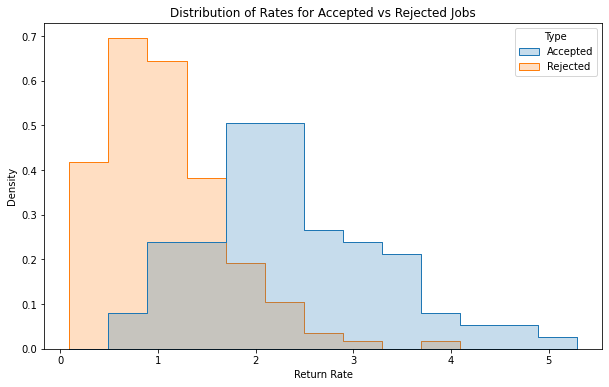

In [539]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize empty lists
accepted_return_rates = []
accepted_expected_lengths = []
accepted_requirements = []
rejected_return_rates = []
rejected_expected_lengths = []
rejected_requirements = []

# Assume accepted_jobs and rejected_jobs are your lists of accepted and rejected Job objects
# Can switch between coputers and mine
for job in my_accepted:
    accepted_return_rates.append(job.return_rate())
    accepted_expected_lengths.append(job.expected_length())
    accepted_requirements.append(job.resource_requirement)

for job in my_rejected:
    rejected_return_rates.append(job.return_rate())
    rejected_expected_lengths.append(job.expected_length())
    rejected_requirements.append(job.resource_requirement)

# Create DataFrames
df_accepted = pd.DataFrame({
    'Return Rate': accepted_return_rates,
    'Expected Length': accepted_expected_lengths,
    'Requirements': accepted_requirements,
    'Type': ['Accepted'] * len(accepted_return_rates)
})

df_rejected = pd.DataFrame({
    'Return Rate': rejected_return_rates,
    'Expected Length': rejected_expected_lengths,
    'Requirements': rejected_requirements,
    'Type': ['Rejected'] * len(rejected_return_rates)
})

# Combine into one DataFrame
df = pd.concat([df_accepted, df_rejected])

# Plot 1: Pair of histograms/kdes for rates
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Return Rate', hue='Type', element='step', stat='density', common_norm=False)
plt.title('Distribution of Rates for Accepted vs Rejected Jobs')
plt.show()

<Figure size 720x432 with 0 Axes>

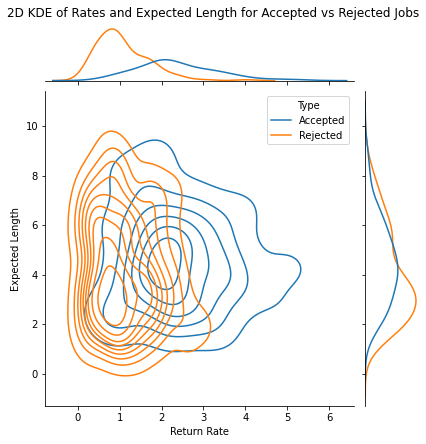

In [540]:
# Plot 2: 2D kde/histogram for rates and expected length
plt.figure(figsize=(10, 6))
sns.jointplot(data=df, x='Return Rate', y='Expected Length', hue='Type', kind='kde')
plt.suptitle('2D KDE of Rates and Expected Length for Accepted vs Rejected Jobs', y=1.02)
plt.show()

<Figure size 720x432 with 0 Axes>

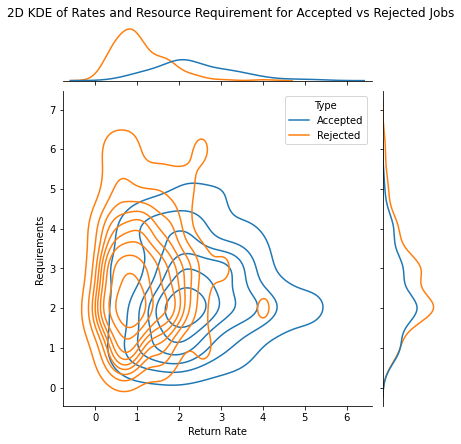

In [541]:
# Plot 3: 2D kde/histogram for rates and resource requirement
plt.figure(figsize=(10, 6))
sns.jointplot(data=df, x='Return Rate', y='Requirements', hue='Type', kind='kde')
plt.suptitle('2D KDE of Rates and Resource Requirement for Accepted vs Rejected Jobs', y=1.02)
plt.show()

In [167]:
len(df_accepted)

65

In [168]:
len(df_rejected)

73

# Creation of jobs for parameter file

In [4]:
jobs = []
for i in range(100):
    jobs_arrived = min(poisson.rvs(mu=2), 7)
    temp_jobs = [create_random_job(f'{i+1}_{k+1}') for k in range(jobs_arrived)]
    for job in temp_jobs:
        job.round = i+1
        job.num_projects = jobs_arrived
    jobs += temp_jobs
rates = [job.return_rate() for job in jobs]
lengths = [job.expected_length() for job in jobs]
reqs = [job.resource_requirement for job in jobs]

In [5]:
data = [['','Player', 'Round', 'NumProjects', 'Project_Id','Payoff','InitialRound','FinalRound','PartsRequired','WorkersRequired','ComplicationProb','SoftDeadline','HardDeadline','ReductionRate','Penalty','InitialWorkers']]
n_players=30
for p in range(n_players):
    for i,job in enumerate(jobs):
        data.append([i+p*n_players, p+1, job.round, job.num_projects, job.name, job.payment, job.round, job.round, job.parts,
                     job.resource_requirement, round(job.complication_probability*100)/100, int(job.soft_deadline), int(job.hard_deadline), 0.85, min(-1,int(-0.2*job.payment)), 10])

In [231]:
import csv
with open('params.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in data:
        csvwriter.writerow(row)

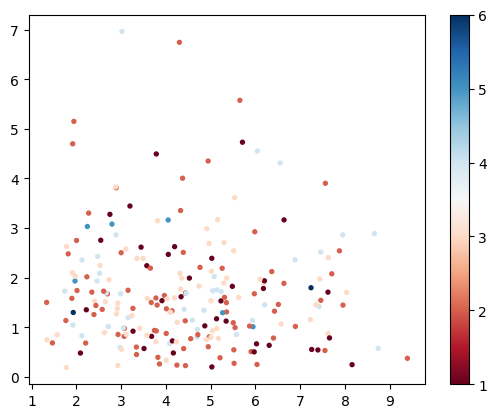

In [222]:
import matplotlib.pyplot as plt
plt.scatter(lengths, rates,  s=8, c=reqs, cmap='RdBu')
plt.colorbar()

(array([55., 64., 54., 27., 12.,  5.,  6.,  2.,  0.,  2.]),
 array([0.18795566, 0.86534264, 1.54272963, 2.22011661, 2.89750359,
        3.57489057, 4.25227755, 4.92966454, 5.60705152, 6.2844385 ,
        6.96182548]),
 <BarContainer object of 10 artists>)

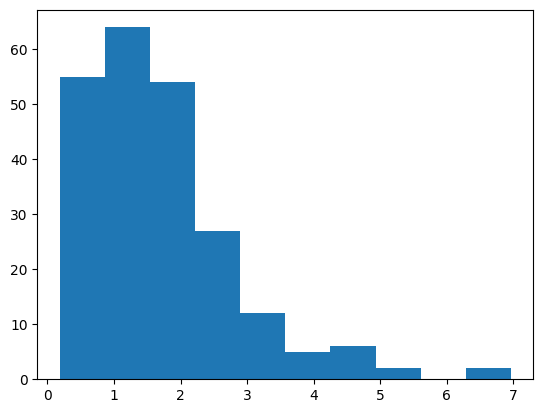

In [223]:
plt.hist(rates)